# Social Graphs and Interaction - Assignment 2

Group 75  
Ben Berger - s252255  
Duco Lam - s252126

# Imports and Setup

All the files required to build the network and genres, and the Hedonometer.csv used in part 4 can also be downloaded from GitHub https://github.com/badumts78/Social-Graphs/tree/main/Assignment2

In [45]:
# Imports
# To install sklearn: pip install scikit-learn
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os
import re
import ast
import random
import statistics
import math
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from pathlib import Path
from typing import List, Dict, Optional
from collections import Counter, defaultdict

In [46]:
# Create Graph
G = nx.DiGraph()

files = os.listdir("Musicians")

for file in files:
    filepath = "Musicians/" + file
    with open(filepath, "r") as f:
        G.add_node(file.replace(".txt", ''), length_of_content = len(f.read().split()))

for file in files:
    filepath = "Musicians/" + file
    with open(filepath, "r") as f:
        filecontent = f.read()

        links = re.findall(r'\[\[([^|\]#]+)(?:#[^\]]*)?(?:\|([^\]]+))?\]\]', filecontent)

        for link, _ in links:
            link = link.replace("\\", "")
            link = link.replace('/', ' ')
            if link in list(G.nodes):
                G.add_edge(file.replace(".txt", ''), link.replace('/', ' '))

noConnections = [node for node in G.nodes if (G.out_degree(node) == 0 and G.in_degree(node) == 0)]

G.remove_nodes_from(noConnections)

largest_wcc = max(nx.weakly_connected_components(G), key=len)

GL = G.subgraph(largest_wcc).copy()

G_und = GL.to_undirected() 

In [47]:
def normalize_genre(genre_text: str) -> Optional[str]:
    """
    Cleans, lowercases, and normalizes a single genre string.
    """
    # Clean and lowercase
    g = genre_text.lower().strip()
    
    if not g:
        return None
    
    g = g.replace('-', ' ')
        
    # Normalize "rock'n'roll", "rock & roll", etc.
    # This rule is intentionally broad to catch variations.
    if 'rock' in g and ('roll' in g or '’n’' in g or '&' in g or "'n'" in g):
        return 'rock and roll'
    
    g = g.replace('&', 'and')
    
    if 'early' in g:
        g = g.replace(' (early)', '')
    
    if 'later' in g:
        g = g.replace(' (later)', '')
        
        
    # Add any other normalization rules here
    # For example:
    # if g == 'r&b':
    #     return 'r&b'
        
    return g

def extract_all_genres(directory_path: str) -> Dict[str, List[str]]:
    """
    Extracts genres for all artists from wikitext files in a directory.
    
    Args:
        directory_path: The path to the folder containing artist .txt files.

    Returns:
        A dictionary mapping artist names to a list of their genres.
    """
    artist_genres_map: Dict[str, List[str]] = {}
    p = Path(directory_path)
    
    if not p.is_dir():
        print(f"Error: Directory not found at {directory_path}")
        return {}

    # Define regex patterns
    # 1. Finds the main infobox
    infobox_re = re.compile(
        r"\{\{Infobox musical artist[\s\S]*?^\}\}", 
        re.MULTILINE | re.IGNORECASE
    )
    
    # 2. Finds the genre line within the infobox
    # This version stops when it sees the *next parameter* (e.g. "| label =")
    # or the end of the infobox, rather than just any line starting with "|".
    genre_line_re = re.compile(
        r"\| *genre *= *([\s\S]*?)\n *(?=\| *[a-z_ ]+ *=|^\}\})", 
        re.MULTILINE | re.IGNORECASE
    )
    
    # 3-7. Cleaning regex patterns
    link_display_re = re.compile(r"\[\[[^|\]]+\|([^\]]+)\]\]") # [[link|display]] -> display
    link_re = re.compile(r"\[\[([^\]]+)\]\]")                 # [[link]] -> link
    # NEW: Separator for adjacent links like ]] [[
    link_separator_re = re.compile(r"\]\](\s+)\[\[")
    
    list_template_re = re.compile(                           # {{hlist|a|b}} -> a|b
        r"\{\{(?:hlist|flatlist|unbulleted list)\s*\|([\s\S]*?)\}\}", 
        re.IGNORECASE
    )
    other_template_re = re.compile(r"\{\{[^}]+\}\}")         # {{template}} -> ""
    comment_re = re.compile(r"<!--[\s\S]*?-->")              # <!-- comment --> -> ""
    ref_re = re.compile(r"<ref[\s\S]*?(/>|</ref>)", re.IGNORECASE) # <ref ... /> -> ""
    # UPDATED: Add <br> variants to the separator list
    separator_re = re.compile(r"[|\n*]|<br */?>", re.IGNORECASE) # |, \n, *, <br> -> ,

    for file_path in p.glob('*.txt'):
        artist_name = file_path.stem
        wikitext = ""
        
        try:
            # Read the raw content
            raw_content = file_path.read_text(encoding='utf-8')
            
            # Try to parse as the 'ast' structure from your example
            try:
                data = ast.literal_eval(raw_content)
                page_id = list(data.keys())[0] # Get the first (only) page ID
                wikitext = data[page_id]['revisions'][0]['*']
            except (ValueError, SyntaxError, KeyError, IndexError, TypeError):
                # Fallback: assume the file is just raw wikitext
                wikitext = raw_content
                
            if not wikitext:
                print(f"No wikitext found for {artist_name}")
                continue

            # 1. Find infobox
            infobox_match = infobox_re.search(wikitext)
            if not infobox_match:
                # print(f"No infobox found for {artist_name}")
                continue
            
            infobox_text = infobox_match.group(0)

            # 2. Find genre line
            genre_match = genre_line_re.search(infobox_text)
            if not genre_match:
                # print(f"No genre line found for {artist_name}")
                continue
                
            content = genre_match.group(1)

            # --- Start cleaning the extracted genre content ---
            # The order of these operations is critical.
            
            # 0. Replace HTML entities like &nbsp;
            content = content.replace('&nbsp;', ' ')
            
            # 1. Remove HTML comments <!-- ... -->
            content = comment_re.sub("", content)
            # 2. Remove <ref> tags (which can contain nested templates)
            content = ref_re.sub("", content)
            
            # 3. NEW: Insert a separator (pipe) between adjacent links: ]] [[ -> ]] | [[
            # This handles cases like [[hard rock]] [[arena rock]]
            content = link_separator_re.sub(r"]]|\1[[", content)
            
            # 4. Simplify hlist/flatlist templates: {{hlist|a|b|c}} -> a|b|c
            content = list_template_re.sub(r"\1", content)
            # 5. Remove any other simple templates {{template}} -> ""
            content = other_template_re.sub("", content)
            # 6. Resolve links: [[link|display]] -> display
            content = link_display_re.sub(r"\1", content)
            # 7. Resolve links: [[link]] -> link
            content = link_re.sub(r"\1", content)
            # 8. Replace common separators (pipe, newline, asterisk, <br>) with commas
            content = separator_re.sub(",", content)
            
            # 9. Final cleanup: strip whitespace and any trailing template braces
            content = content.strip().rstrip('}')
            # --- Done cleaning ---

            # 10. Split by comma and process each potential genre
            potential_genres = content.split(',')
            genres_list = []
            
            for g_text in potential_genres:
                # Extra cleanup for trailing braces on individual items
                g_clean = g_text.strip().rstrip('}')
                
                # Skip any empty strings or leftover template/HTML bits
                # ADDED: Filter out template parameters (like 'italic=no' by checking for '=')
                # ADDED: Filter out very short items (like 'de' by checking length > 2)
                if (g_clean and
                    not g_clean.startswith('<') and
                    not g_clean.startswith('{') and
                    'class=' not in g_clean and
                    '=' not in g_clean and
                    len(g_clean) > 2):
                    
                    normalized = normalize_genre(g_clean)
                    if normalized:
                        genres_list.append(normalized)

            # 11. Add to map if we found any genres
            if genres_list:
                # Remove duplicates and sort
                unique_genres = list(set(genres_list))
                artist_genres_map[artist_name] = unique_genres

        except Exception as e:
            print(f"Error processing {artist_name} ({file_path.name}): {e}")
            
    return artist_genres_map


genre_dict = extract_all_genres("Musicians")

# Part 1: Analyze the network

**We want to present the some important facts about the network that results from the links between pages from rock musicians on wikipedia.**

**We start of with some basic facts on the network:**

**What is the number of nodes?**

**What is the number of edges?**

**What are the average, median, mode, minimum and maximum value of the in-degree and of the out-degree?**

In [48]:
in_degrees = dict(GL.in_degree())
out_degrees = dict(GL.out_degree())

nodes = list(GL.nodes())
x_out = [out_degrees[n] for n in nodes]
y_in  = [in_degrees[n] for n in nodes]

def compute_stats(values):
    return {
        "average": sum(values) / len(values),
        "median": statistics.median(values),
        "mode": statistics.mode(values),
        "min": min(values),
        "max": max(values) ,
    }

in_stats = compute_stats(y_in)
out_stats = compute_stats(x_out)

print(f"The network has {len(GL.nodes)} nodes and {len(GL.edges)} edges.")
print(f"The average degree of the nodes is {in_stats["average"]:.2f}.")
print(f"The median of the in-degrees is {in_stats["median"]}, the mode is {in_stats["mode"]}, the minimum is {in_stats["min"]}, and the maximum is {in_stats["max"]}.")
print(f"If we compare this to the out-degrees, we notice that the out-degree distribution seems to be different, since the median is {out_stats["median"]}, the mode is {out_stats["mode"]}, the minimum is {out_stats["min"]}, and the maximum is {out_stats["max"]}.")

The network has 484 nodes and 7329 edges.
The average degree of the nodes is 15.14.
The median of the in-degrees is 10.0, the mode is 4, the minimum is 0, and the maximum is 119.
If we compare this to the out-degrees, we notice that the out-degree distribution seems to be different, since the median is 13.0, the mode is 12, the minimum is 0, and the maximum is 74.


**To investigate this further, we will now plot the in- and out-degree distribution**

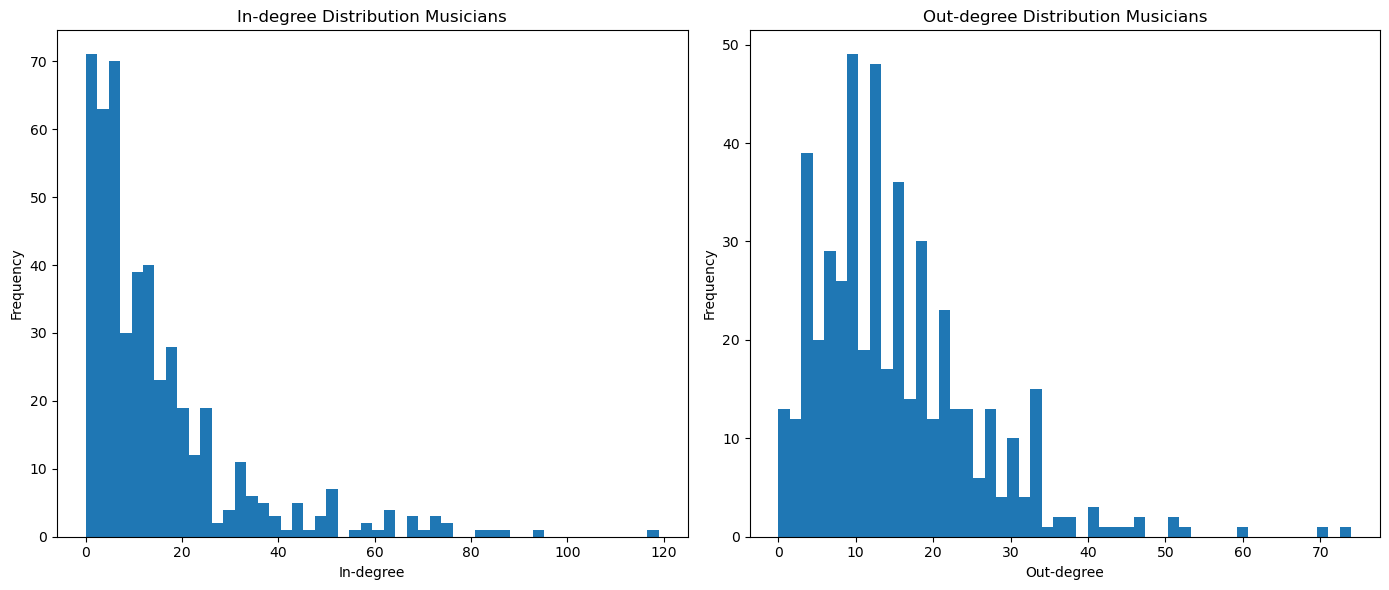

In [49]:
number_bins = 50

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.hist([x for x in y_in], bins=number_bins)
plt.xlabel("In-degree")
plt.ylabel("Frequency")
plt.title("In-degree Distribution Musicians")

plt.subplot(1,2,2)
plt.hist([x for x in x_out], bins=number_bins)
plt.xlabel("Out-degree")
plt.ylabel("Frequency")
plt.title("Out-degree Distribution Musicians")
plt.tight_layout()
plt.show()

On the left, we have the in-degree distribution, and on the right, the out-degree distribution.  
We can see that most musicians have an in-degree of 0 or a very small one, and a few musicians have a very high in-degree. The out-degree follows more of a normal distribution.   
Our theory is that many musicians draw inspiration from a very small group of highly influential musicians. 

**To investigate this further we will now look into the degree distributions of the individual musicians in more detail.**

**First, we will create a scatter plot, where each point is a musician, and the axes show in- versus out-degree**

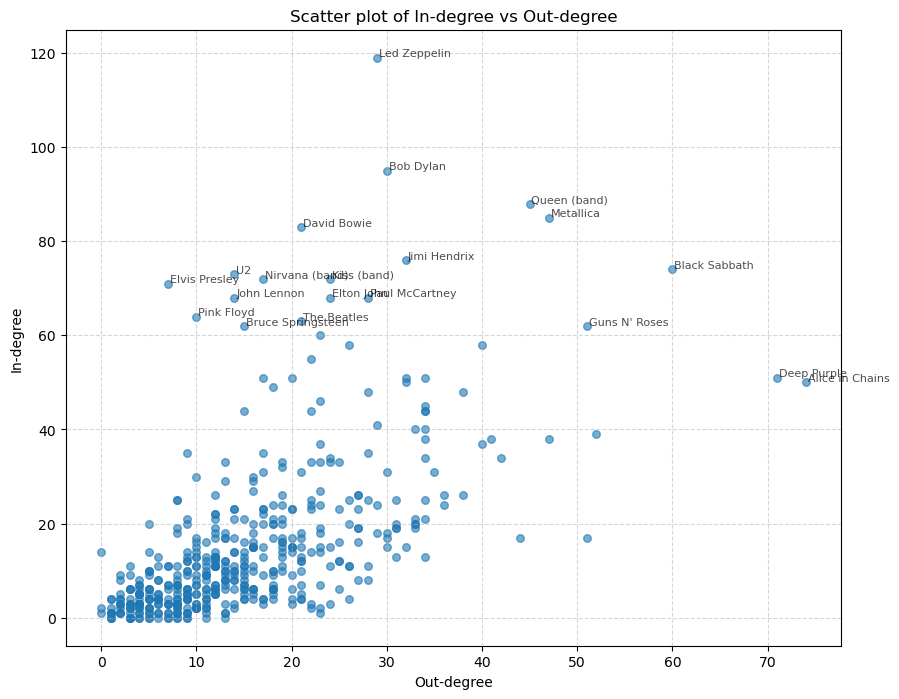

In [50]:
plt.figure(figsize=(10, 8))
plt.scatter(x_out, y_in, alpha=0.6, s=30)

for i, node in enumerate(nodes):
    if x_out[i] > 60 or y_in[i] > 60:
        plt.text(x_out[i]+0.2, y_in[i]+0.2, str(node), fontsize=8, alpha=0.7)

plt.xlabel("Out-degree")
plt.ylabel("In-degree")
plt.title("Scatter plot of In-degree vs Out-degree")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

This scatter plot shows the in- versus out-degree for each musician. To avoid too much overlapping of names, only the nodes that have an in- or out-degree of over 60 have a label.  
We notice that there are indeed a few musicians with a very high in-degree, who are all well known.  
This supports the theory that these are artists who are often mentioned as an inspiration for other artists.  
We also notice that most musicians have an in- and out-degree of both less than 20. However, we cannot see too much detail due to the many nodes in that area.

**So we will create a heatmap in the next step, that zooms in on just the in-degree $[0,20]$ and out-degree $[0,20]$ area of the plot.**

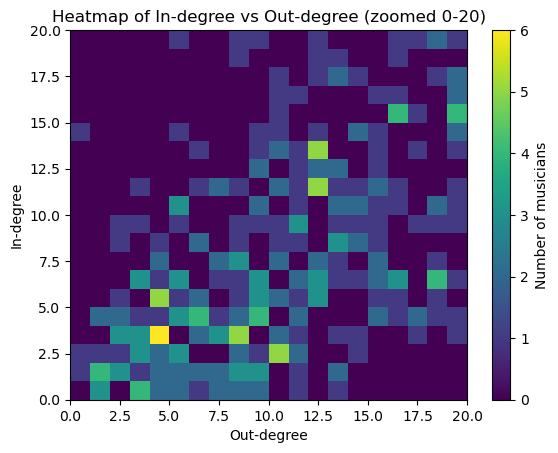

In [51]:
plt.hist2d(
    x_out,
    y_in,
    bins=[20, 20],
    range=[[0, 20], [0, 20]],
    cmap='viridis'
)

plt.colorbar(label="Number of musicians")
plt.xlabel("Out-degree")
plt.ylabel("In-degree")
plt.title("Heatmap of In-degree vs Out-degree (zoomed 0-20)")

plt.show()

This heatmap shows the in- versus out-degree for musicians, zoomed in to the area where both degrees are less than 20.  
We see that the majority of musicians in this area have a lower in-degree than out-degree.  
However, we can also see that there is a correlation between in- and out-degree in this area: when the in-degree gets higher, the out-degree also tends to get higher.  
Our theory is that if musicians engage in collaborations or are an inspiration for other musicians, they become more famous, which leads to longer Wikipedia articles and thus higher out-degrees.

**To investigate this further, we will now calculate the Pearson correlation between the length of the Wikipedia articles and the in- and out-degree for each node.**

In [52]:
lengths = [GL.nodes[n].get('length_of_content', 0) for n in GL.nodes()]
in_degrees_pearson = [GL.in_degree(n) for n in GL.nodes()]
out_degrees_pearson = [GL.in_degree(n) for n in GL.nodes()]

pearson_in  = pearsonr(lengths, in_degrees_pearson)
pearson_out = pearsonr(lengths, out_degrees_pearson)
print(f"The Pearson correlation for the in-degree and article length is {pearson_in.correlation:.4f}, and for the out-degree it is {pearson_out.correlation:.4f}.")
print(f"This indicates a high correlation, which supports the theory that famous characters have longer articles, thus a higher out-degree, and also a higher in-degree because of collaborations or inspiration.")

The Pearson correlation for the in-degree and article length is 0.7022, and for the out-degree it is 0.7022.
This indicates a high correlation, which supports the theory that famous characters have longer articles, thus a higher out-degree, and also a higher in-degree because of collaborations or inspiration.


**Now, we want to investigate the centrality of nodes in our network.**

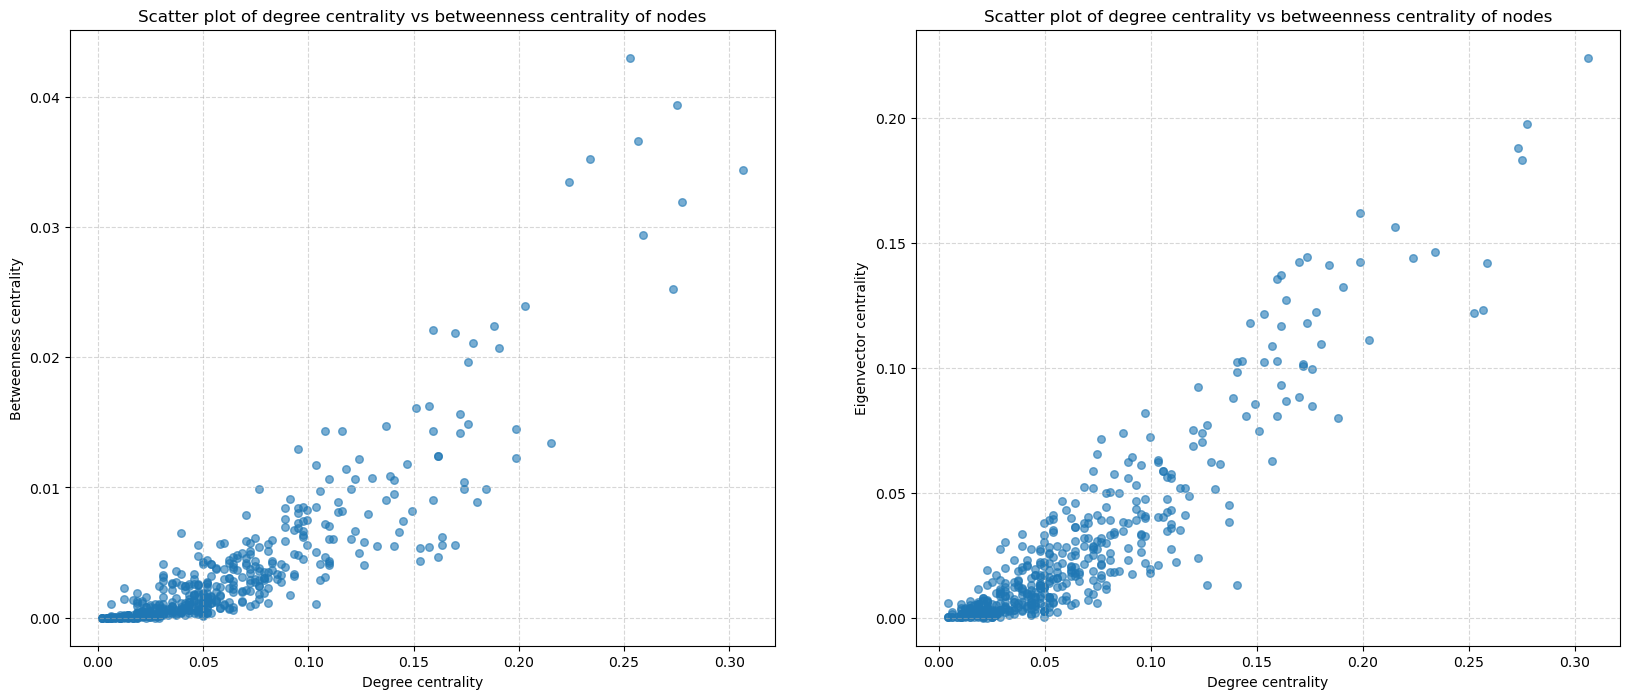

In [53]:
degree_centrality = nx.degree_centrality(GL)
betweenness = nx.betweenness_centrality(GL)

degree_centrality_list = [degree_centrality[n] for n in GL.nodes()]
betweenness_list = [betweenness[n] for n in GL.nodes()]

plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
plt.xlabel("Degree centrality")
plt.ylabel("Betweenness centrality")
plt.title("Scatter plot of degree centrality vs betweenness centrality of nodes")
plt.grid(True, linestyle="--", alpha=0.5)
plt.scatter(degree_centrality_list, betweenness_list, alpha=0.6, s=30)

scc = max(nx.strongly_connected_components(GL), key=len)
G_scc = G.subgraph(scc).copy()
out_eig = nx.eigenvector_centrality(G_scc)

degree_centrality_scc = nx.degree_centrality(G_scc)
degree_centrality_list_scc = [degree_centrality[n] for n in G_scc.nodes()]
out_eig_list = [out_eig[n] for n in G_scc.nodes()]

plt.subplot(1,2,2)
plt.xlabel("Degree centrality")
plt.ylabel("Eigenvector centrality")
plt.title("Scatter plot of degree centrality vs betweenness centrality of nodes")
plt.grid(True, linestyle="--", alpha=0.5)
plt.scatter(degree_centrality_list_scc, out_eig_list, alpha=0.6, s=30)
plt.show()


On the left, we can see a scatter plot of degree centrality versus betweenness centrality for each node of the network.  
There is a correlation between the centralities, but it is difficult to tell for certain if it is a linear or exponential correlation.  
The correlation makes sense: nodes that have a high degree will also be in many shortest paths since they can connect many nodes.

On the right, we can see the scatter plot of degree centrality versus eigenvector centrality for each node of the network.  
Here, we also find a correlation; in this case, it tends to be linear.  
This could be explained by the fact that famous musicians have a high degree centrality and tend to connect to other famous musicians, because of collaborations and influences.

**So in the next step, we want to look at assortativity in our network, i.e. do nodes with similar attributes tend to connect to one another.**  
**We will test the assortativity of both the degree and the length of content as attributes on the undirected version of the network**

In [54]:
G_und_with_degree_attribute = G_und.copy()

degrees = dict(G_und_with_degree_attribute.degree())

nx.set_node_attributes(G_und_with_degree_attribute, degrees, "degree")

deg_asso = nx.attribute_assortativity_coefficient(G_und_with_degree_attribute, "degree")
loc_asso = nx.attribute_assortativity_coefficient(G_und_with_degree_attribute, "length_of_content")

print(f"Both coefficients, for the degree assortativity {deg_asso:.4f} as well as for the length of content assortativity {loc_asso:.4f}, are close to 0. This means the network is non-assortative for these attributes.")
print("A reason for that could be that musicians who are not as famous, meaning lower degree and shorter articles, tend to connect to famous musicians, where they may get inspiration, as well as other non-famous musicians, perhaps because of collaborations.")
print("The famous musicians are then connected to the unfamous ones because the graph is undirected, and they also collaborate with or are influenced by other famous musicians.")

Both coefficients, for the degree assortativity -0.0026 as well as for the length of content assortativity -0.0027, are close to 0. This means the network is non-assortative for these attributes.
A reason for that could be that musicians who are not as famous, meaning lower degree and shorter articles, tend to connect to famous musicians, where they may get inspiration, as well as other non-famous musicians, perhaps because of collaborations.
The famous musicians are then connected to the unfamous ones because the graph is undirected, and they also collaborate with or are influenced by other famous musicians.


**The last thing we want to do is investigate the backbone of the network using the Disparity Filter.**

In [55]:
# Code from https://www.michelecoscia.com/?page_id=287
def disparity_filter(table, undirected = False, return_self_loops = False):
   # sys.stderr.write("Calculating DF score...\n")
   table = table.copy()
   table_sum = table.groupby(table["src"]).sum().reset_index()
   table_deg = table.groupby(table["src"]).count()["trg"].reset_index()
   table = table.merge(table_sum, on = "src", how = "left", suffixes = ("", "_sum"))
   table = table.merge(table_deg, on = "src", how = "left", suffixes = ("", "_count"))
   table["score"] = 1.0 - ((1.0 - (table["nij"] / table["nij_sum"])) ** (table["trg_count"] - 1))
   table["variance"] = (table["trg_count"] ** 2) * (((20 + (4.0 * table["trg_count"])) / ((table["trg_count"] + 1.0) * (table["trg_count"] + 2) * (table["trg_count"] + 3))) - ((4.0) / ((table["trg_count"] + 1.0) ** 2)))
   if not return_self_loops:
      table = table[table["src"] != table["trg"]]
   if undirected:
      table["edge"] = table.apply(lambda x: "%s-%s" % (min(x["src"], x["trg"]), max(x["src"], x["trg"])), axis = 1)
      table_maxscore = table.groupby(by = "edge")["score"].max().reset_index()
      table_minvar = table.groupby(by = "edge")["variance"].min().reset_index()
      table = table.merge(table_maxscore, on = "edge", suffixes = ("_min", ""))
      table = table.merge(table_minvar, on = "edge", suffixes = ("_max", ""))
      table = table.drop_duplicates(subset = ["edge"])
      
      # *** CORRECTION APPLIED HERE ***
      table = table.drop("edge", axis=1)
      table = table.drop("score_min", axis=1)
      table = table.drop("variance_max", axis=1)
      # *******************************
      
   return table[["src", "trg", "nij", "score", "variance"]]

def high_salience_skeleton(table, undirected = False, return_self_loops = False):
   sys.stderr.write("Calculating HSS score...\n")
   table = table.copy()
   table["distance"] = 1.0 / table["nij"]
   nodes = set(table["src"]) | set(table["trg"])
   G = nx.from_pandas_edgelist(table, source = "src", target = "trg", edge_attr = "distance", create_using = nx.DiGraph())
   cs = defaultdict(float)
   for s in nodes:
      pred = defaultdict(list)
      dist = {t: float("inf") for t in nodes}
      dist[s] = 0.0
      Q = defaultdict(list)
      for w in dist:
         Q[dist[w]].append(w)
      S = []
      while len(Q) > 0:
         v = Q[min(Q.keys())].pop(0)
         S.append(v)
         for _, w, l in G.edges(nbunch = [v,], data = True):
            new_distance = dist[v] + l["distance"]
            if dist[w] > new_distance:
               Q[dist[w]].remove(w)
               dist[w] = new_distance
               Q[dist[w]].append(w)
               pred[w] = []
            if dist[w] == new_distance:
               pred[w].append(v)
         while len(S) > 0:
            w = S.pop()
            for v in pred[w]:
               cs[(v, w)] += 1.0
         Q = defaultdict(list, {k: v for k, v in Q.items() if len(v) > 0})
   table["score"] = table.apply(lambda x: cs[(x["src"], x["trg"])] / len(nodes), axis = 1)
   if not return_self_loops:
      table = table[table["src"] != table["trg"]]
   if undirected:
      table["edge"] = table.apply(lambda x: "%s-%s" % (min(x["src"], x["trg"]), max(x["src"], x["trg"])), axis = 1)
      table_maxscore = table.groupby(by = "edge")["score"].sum().reset_index()
      table = table.merge(table_maxscore, on = "edge", suffixes = ("_min", ""))
      table = table.drop_duplicates(subset = ["edge"])
      table = table.drop("edge", 1)
      table = table.drop("score_min", 1)
      table["score"] = table["score"] / 2.0
   return table[["src", "trg", "nij", "score"]]

In [56]:
edge_betweenness = nx.edge_betweenness_centrality(G_und, normalized=False)

def normalize_to_range(data, min_new, max_new):
    min_old = min(data)
    max_old = max(data)
    
    new_range = max_new - min_new
    old_range = max_old - min_old
    
    scaled_data = []

    for i in data:
        scaled_data.append(min_new + (i - min_old) * new_range / old_range)
    
    return scaled_data


keys = list(edge_betweenness.keys())
raw_scores = list(edge_betweenness.values())

normalized_weights = normalize_to_range(raw_scores, 1, 100)

In [57]:
edge_table = pd.DataFrame({
    'src': [edge[0] for edge in keys],
    'trg': [edge[1] for edge in keys],
    'nij': normalized_weights
})

result_filter = disparity_filter(edge_table, undirected=True)

In [58]:
other_normalized_weights = [1/x for x in normalized_weights]
edge_table2 = pd.DataFrame({
    'src': [edge[0] for edge in keys],
    'trg': [edge[1] for edge in keys],
    'nij': other_normalized_weights
})

result_filter2 = disparity_filter(edge_table, undirected=True)

In [59]:
result_filter.drop(result_filter[result_filter.score < 0.75].index, inplace=True)

G_backbone = nx.from_pandas_edgelist(
    result_filter,
    source='src',
    target='trg',
    create_using=nx.Graph()  # Use nx.Graph() for the undirected result
)

largest_cc = max(nx.connected_components(G_backbone), key=len)
G_backbone = G_backbone.subgraph(largest_cc)

pose = nx.forceatlas2_layout(G_backbone, max_iter=1000)

In [60]:
result_filter2.drop(result_filter2[result_filter2.score < 0.75].index, inplace=True)

G_backbone2 = nx.from_pandas_edgelist(
    result_filter2,
    source='src',
    target='trg',
    create_using=nx.Graph()  # Use nx.Graph() for the undirected result
)

largest_cc2 = max(nx.connected_components(G_backbone2), key=len)
G_backbone2 = G_backbone2.subgraph(largest_cc2)

pose2 = nx.forceatlas2_layout(G_backbone2, max_iter=1000)

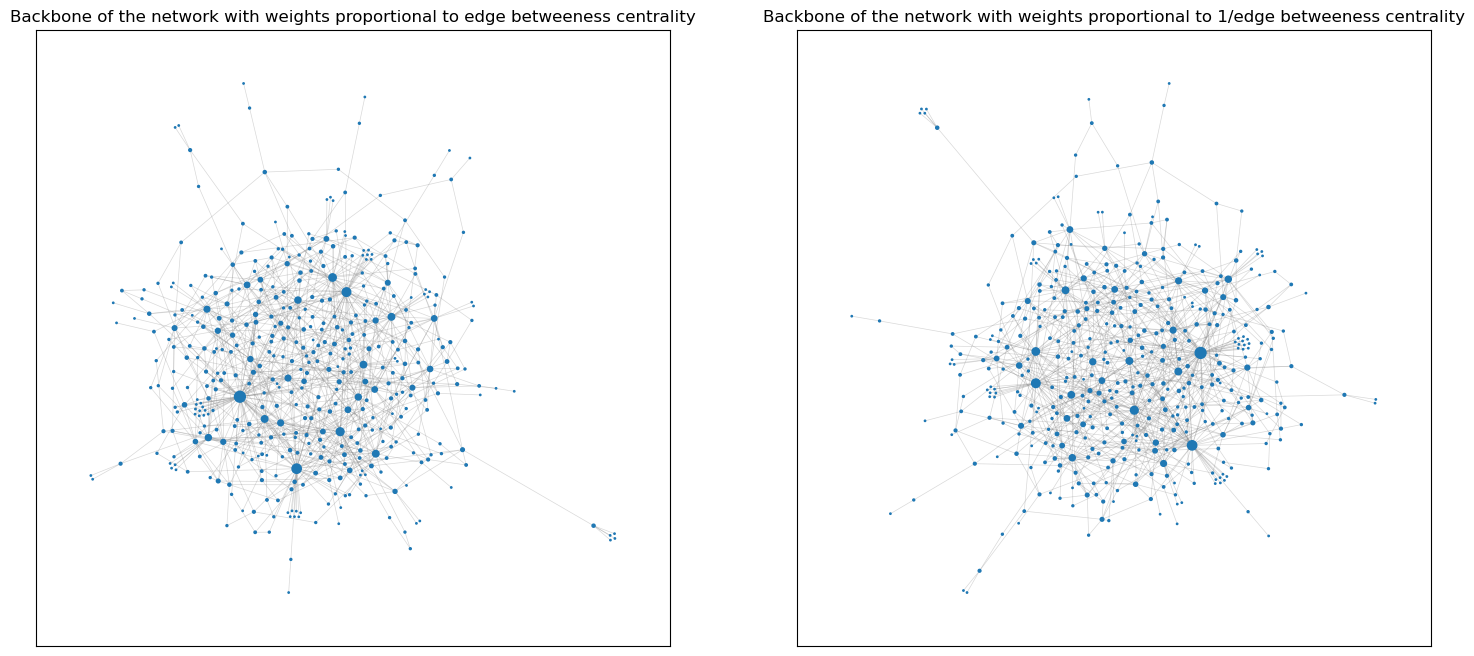

In [ ]:
node_degrees = dict(G_backbone.degree())
node_sizes = [node_degrees[n] for n in G_backbone.nodes()]
max_degree = max(node_sizes)
scaled_sizes = [100 * (v / max_degree) for v in node_sizes] 

plt.figure(figsize=(18, 8))

plt.subplot(1,2,1)
nx.draw_networkx_nodes(
    G_backbone, 
    pos=pose, 
    node_size=node_sizes,
    alpha=1.0
)
nx.draw_networkx_edges(
    G_backbone, 
    pos=pose, 
    edge_color='gray',  
    width=0.5,
    alpha=0.3
)
plt.title("Backbone of the network with weights proportional to edge betweeness centrality")

node_degrees2 = dict(G_backbone2.degree())
node_sizes2 = [node_degrees2[n] for n in G_backbone2.nodes()]
max_degree2 = max(node_sizes2)
scaled_sizes2 = [100 * (v / max_degree2) for v in node_sizes2] 
plt.subplot(1,2,2)
nx.draw_networkx_nodes(
    G_backbone2, 
    pos=pose2, 
    node_size=node_sizes2,
    alpha=1.0
)
nx.draw_networkx_edges(
    G_backbone2, 
    pos=pose2, 
    edge_color='gray',  
    width=0.5,
    alpha=0.3
)
plt.title("Backbone of the network with weights proportional to 1/edge betweeness centrality")

plt.show()

On the left we can see the backbone of the network, where the weights for the disparity filter is the edge betweenness centrality, and on the right the weight is 1/edge betweenness centrality.

# Part 2: Genres and communities and plotting 

**We extracted the genre of all musicians with the help of the infoboxes from Wikipedia. We will start investigating the genres by calculating the number of nodes for which we could find a genre, the average number of genres per node, the total number of distinct genres, and a histogram showing artist counts for the top 15 genres.**


--- Genre Statistics ---
Nodes with genres found: 425
Average genres per node: 3.75
Total distinct genres:   189


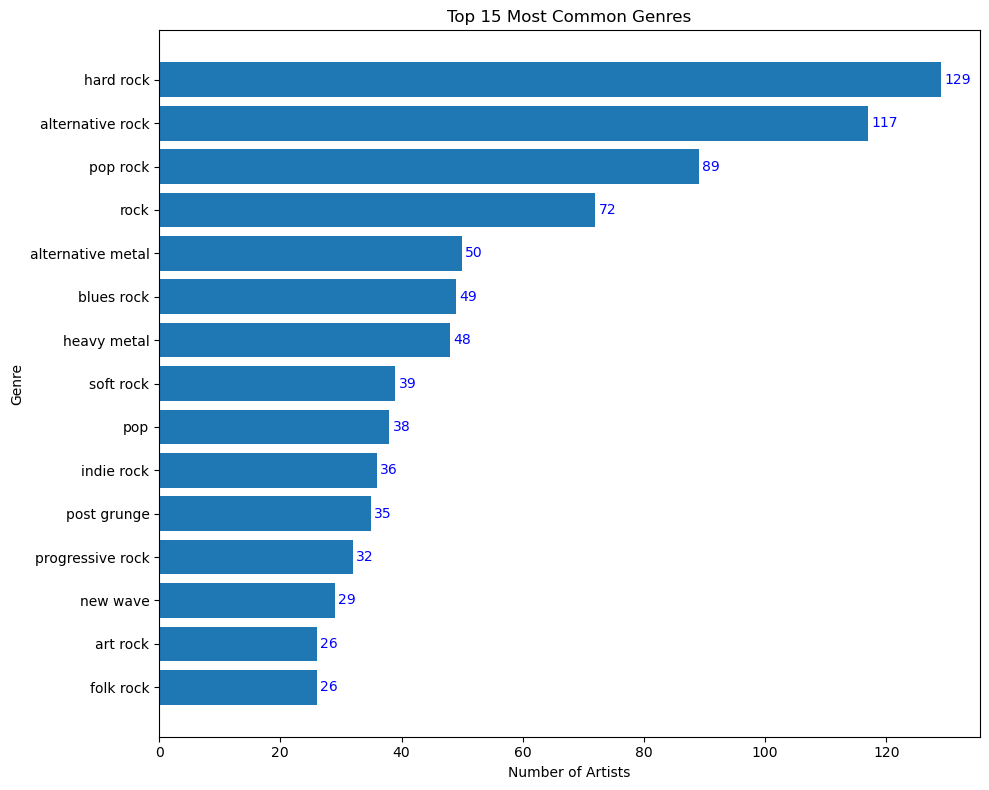

In [62]:
# As suggested in the part 2 of week 5, we used an LLM to extract the genres and report on the statistics, with extensive testing and revisions to ensure everything works as expected

def report_genre_stats(artist_genres_map: Dict[str, List[str]]):
    """
    Calculates and prints genre statistics, then displays a bar chart.
    """
    print("\n--- Genre Statistics ---")
    
    # 1. Number of nodes with genres
    num_nodes_with_genres = len(artist_genres_map)
    if num_nodes_with_genres == 0:
        print("No genres found for any artists.")
        return
        
    print(f"Nodes with genres found: {num_nodes_with_genres}")

    # 2. Average number of genres per node
    total_genres_assigned = sum(len(genres) for genres in artist_genres_map.values())
    avg_genres = total_genres_assigned / num_nodes_with_genres
    print(f"Average genres per node: {avg_genres:.2f}")

    # 3. Total number of distinct genres
    all_genres_list = [genre for genres in artist_genres_map.values() for genre in genres]
    distinct_genres = set(all_genres_list)
    num_distinct_genres = len(distinct_genres)
    print(f"Total distinct genres:   {num_distinct_genres}")

    # 4. Histogram for top 15 genres
    
    genre_counts = Counter(all_genres_list)
    top_15_genres = genre_counts.most_common(15)
    
    if not top_15_genres:
        print("No genre data to display.")
        return

    # Unzip the data for plotting
    # We reverse the lists [::-1] so the highest bar is at the top
    genres = [genre for genre, count in top_15_genres][::-1]
    counts = [count for genre, count in top_15_genres][::-1]

    # Create horizontal bar plot
    plt.figure(figsize=(10, 8))
    plt.barh(genres, counts)
    plt.xlabel('Number of Artists')
    plt.ylabel('Genre')
    plt.title('Top 15 Most Common Genres')
    
    # Add counts to the end of the bars
    for i, v in enumerate(counts):
        plt.text(v + 0.5, i, str(v), color='blue', va='center')

    plt.tight_layout()  # Adjust plot to prevent label overlap
    plt.show()          # Display the plot

report_genre_stats(genre_dict)

We find that almost all the nodes have at least one genre. There are a few genres which have a high number of artists, but the number of artists per genre decreases drastically, even among the 15 most common genres. There seem to be a lot of subgenres of rock, in our case 189.

**Now, we want to try if genres are good at detecting communities in the network. However, since each artist has an average of 3.75 genres, the question is which one to choose.**

In [78]:
# Again used the help of an LLM to calculate the modality
random.seed(42)
def calculate_modularity(G, partition):

    nodes_in_partition = set(partition.keys())
        
    G_partitioned = G.subgraph(nodes_in_partition).copy()
    
    L = G_partitioned.number_of_edges()

    two_L = 2.0 * L
    
    # Calculate Modularity using Equation 9.12
    # M = Σ_c [ (L_c / L) - (k_c / 2L)^2 ]
    
    communities = {}
    for node, comm in partition.items():
        if comm not in communities:
            communities[comm] = []
        communities[comm].append(node)
    
    degrees = dict(G_partitioned.degree())
    
    modularity_sum = 0.0
    for comm_name, nodes_in_comm in communities.items():

        comm_subgraph = G_partitioned.subgraph(nodes_in_comm)
        L_c = comm_subgraph.number_of_edges()
        
        k_c = 0.0
        for node in nodes_in_comm:
            k_c += degrees[node]
            
        term_1 = L_c / L
        term_2 = (k_c / two_L)**2
        
        modularity_sum += (term_1 - term_2)
        
    M = modularity_sum
        
    return len(communities), M


def calculate_genre_modularity(artist_genres_map: Dict[str, List[str]], which_mode):    
    nodes_with_genres = set(artist_genres_map.keys())
    nodes_in_graph = set(G_und.nodes())
    
    valid_nodes = nodes_with_genres.intersection(nodes_in_graph)

    G_filtered = G_und.subgraph(valid_nodes).copy()

    partition = {}
    for node in G_filtered.nodes():
        if artist_genres_map.get(node):
            if which_mode == 0:
                first_genre = artist_genres_map[node][0]
            elif which_mode == 1:
                temp = 0
                if len(artist_genres_map[node]) > 1:
                    temp = 1
                first_genre = artist_genres_map[node][temp]
            elif which_mode == 2:
                first_genre = artist_genres_map[node][random.randint(0, len(artist_genres_map[node])-1)]
            else:
                temp = 0
                if len(artist_genres_map[node]) > 1 and artist_genres_map[node][0] == "hard rock":
                    temp = 1
                first_genre = artist_genres_map[node][temp]
            partition[node] = first_genre
    
    return calculate_modularity(G_filtered, partition)
    

print("We try 3 different methods of selecting the genre. We use modularity as the measure of how good our communities are.\n")
num_comm, modula = calculate_genre_modularity(genre_dict, 0)
print(f"When we use the first genre as a variable for community detection, we get {num_comm} unique communities and a modularity measure of {modula:.4f}.")
num_comm, modula = calculate_genre_modularity(genre_dict, 1)
print(f"When we use the second genre as a variable for community detection (if a second genre exists; otherwise, the first genre), we get {num_comm} unique communities and a modularity measure of {modula:.4f}.")
num_comm, modula = calculate_genre_modularity(genre_dict, 2)
print(f"When we use a random genre as a variable for community detection, we get {num_comm} unique communities and a modularity measure of {modula:.4f} (with seed 42).") 
print("\nOverall, we can see that the genre is not great for community detection. All modularity measures are positive but close to 0, suggesting we are in between a suboptimal partition and a single community.")

We try 3 different methods of selecting the genre. We use modularity as the measure of how good our communities are.

When we use the first genre as a variable for community detection, we get 89 unique communities and a modularity measure of 0.0911.
When we use the second genre as a variable for community detection (if a second genre exists; otherwise, the first genre), we get 100 unique communities and a modularity measure of 0.0448.
When we use a random genre as a variable for community detection, we get 108 unique communities and a modularity measure of 0.0454 (with seed 42).

Overall, we can see that the genre is not great for community detection. All modularity measures are positive but close to 0, suggesting we are in between a suboptimal partition and a single community.


**We will now try another method for community detection: the Louvain algorithm.**

In [79]:
def calculate_modularity_list(G, partition):

    nodes_in_partition = [x for y in partition for x in y]

    G_partitioned = G.subgraph(nodes_in_partition).copy()
    
    L = G_partitioned.number_of_edges()

    two_L = 2.0 * L
    
    # Calculate Modularity using Equation 9.12
    # M = Σ_c [ (L_c / L) - (k_c / 2L)^2 ]
    
    degrees = dict(G_partitioned.degree())
    
    modularity_sum = 0.0
    for nodes_in_comm in partition:

        comm_subgraph = G_partitioned.subgraph(nodes_in_comm)
        L_c = comm_subgraph.number_of_edges()
        
        k_c = 0.0
        for node in nodes_in_comm:
            k_c += degrees[node]
            
        term_1 = L_c / L
        term_2 = (k_c / two_L)**2
        
        modularity_sum += (term_1 - term_2)
        
    M = modularity_sum
        
    return len(partition), M

louv_comm = nx.community.louvain_communities(G_und, seed=42)    
num_comm, modula = calculate_modularity_list(G_und, louv_comm)

print(f"The NetworkX built-in Louvain algorithm has a far better community detection, and for seed 10 it calculates {num_comm} communities which have a modularity score of {modula:.4f}.")

The NetworkX built-in Louvain algorithm has a far better community detection, and for seed 10 it calculates 4 communities which have a modularity score of 0.3414.


**To investigate further how good the genres are for community detection, we calculate now the confusion matrix $D$**

In [65]:
louv_comm = sorted(louv_comm, key=lambda x:len(x), reverse=True)

all_genres_list = [genre for genres in genre_dict.values() for genre in genres]
    
top_7_genres = [x for x,_ in Counter(all_genres_list).most_common(7)]

D = np.zeros((len(louv_comm),len(top_7_genres)))
for i in range(len(louv_comm)):
    for art in louv_comm[i]:
        for j in range(len(top_7_genres)):
            if art in genre_dict:
                if top_7_genres[j] in genre_dict[art]:
                    D[i][j] += 1

print(pd.DataFrame(D, columns=top_7_genres, index=range(1,len(louv_comm)+1)))

   hard rock  alternative rock  pop rock  rock  alternative metal  blues rock  \
1       16.0               7.0      37.0  50.0                0.0        21.0   
2       10.0              81.0      36.0  10.0                6.0         4.0   
3       68.0               4.0      13.0  11.0               16.0        22.0   
4       35.0              25.0       3.0   1.0               28.0         2.0   

   heavy metal  
1          2.0  
2          3.0  
3         39.0  
4          4.0  


We see that most genres could have a definite correlation with some communities, but they also have some noise. We see, e.g., that Heavy Metal is heavily present in Community 3. Blues Rock, and Alternative Rock have clear spikes in two of the communities. Hard Rock, on the other hand, is present in all the communities, which makes sense since this is the most common genre.  
We conclude that it is probably possible to detect communities using genres, but it is difficult because of the noise that some genres are too general.

**Next, we want to display the communities that we found with Louvain.**

In [66]:
pose = nx.forceatlas2_layout(G_und, max_iter=1000)

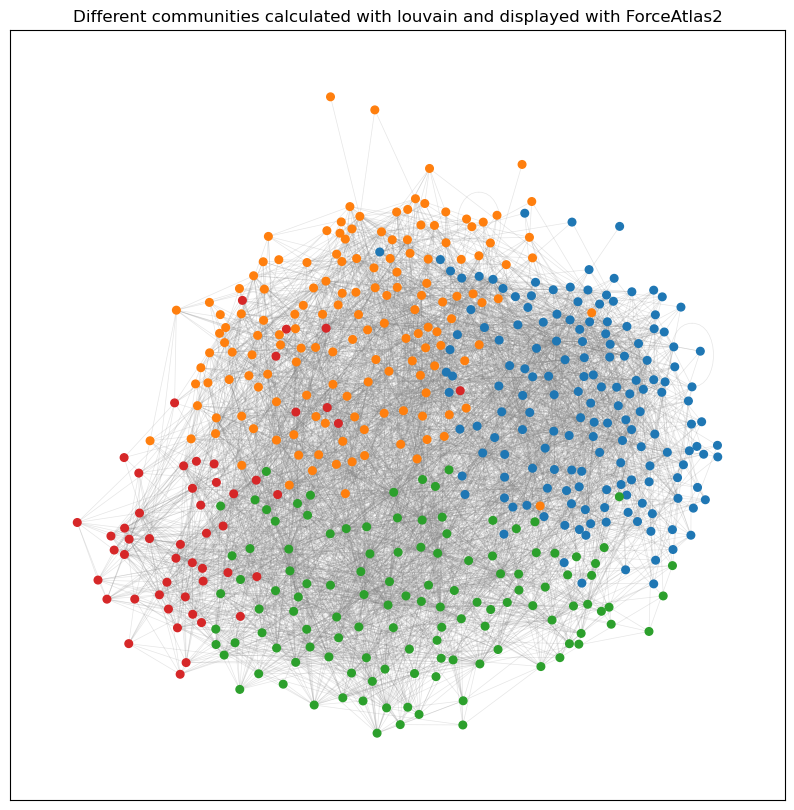

In [67]:
cmap = plt.get_cmap('tab10')

color_map = []

for n in G_und.nodes():
    for i in range(len(louv_comm)):
        if n in louv_comm[i]:
            color_map.append(cmap.colors[i])
            break

plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(
    G_und, 
    pos=pose, 
    node_color=color_map,
    node_size=30,
    alpha=1.0
)
nx.draw_networkx_edges(
    G_und, 
    pos=pose, 
    edge_color='gray',  
    width=0.5,
    alpha=0.2
)
plt.title("Different communities calculated with louvain and displayed with ForceAtlas2")
plt.show()

In the graph above, we can see the network with each community, calculated by the Louvain algorithm, in a different color. The layout is calculated with ForceAtlas2, and we can see that the nodes of the communities are relatively close together, which means that ForceAtlas2 is a great way of displaying these communities.

# Part 3: TF-IDF to understand genres and communities 

 - Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.
 - Calculate and visualize TF-IDF for the genres and communities.
 - Use the matrix D to dicusss the difference between the word-clouds between genres and communities.

Now let’s get into the topic of TF-IDF. Before explaining the maths and formulas, let’s first start with the intuition. Given a statistic for distinguishing words in a page in a book, we would intuitively look at the most common word. However, this would most likely be a word that is common in ALL pages of the book, words like: the, be, to and of. To fix this, we should not only weigh words by how common they are in the single page of the book, but also by how common they are in ALL of the pages of the book. This is the intuition behind TF-IDF. We calculate how common a word is in a single document, and then we weigh it by how common that word is in the entire corpus.

We can use TF-IDF to identify words that are specific to certain genres. we can then relate these words to certain communities to infer which genres represents which community. Say we use TF-IDF on the page for Hip Hop music, we could find identifying words like "rap, beats, 808s". If we then relate these words to a community found within our network, we can reasonably confidently say that that community represents the Hip Hop genre of music.

Lets now apply TF-IDF to our own dataset.

In [68]:
def clean_wikitext(raw_text: str) -> str:
    # We clean using the regex from the genre extraction function
    link_display_re = re.compile(r"\[\[[^|\]]+\|([^\]]+)\]\]")
    link_re = re.compile(r"\[\[([^\]]+)\]\]")
    link_separator_re = re.compile(r"\]\](\s+)\[\[")
    list_template_re = re.compile(r"\{\{(?:hlist|flatlist|unbulleted list)\s*\|([\s\S]*?)\}\}", re.IGNORECASE)
    other_template_re = re.compile(r"\{\{[^}]+\}\}")
    comment_re = re.compile(r"<!--[\s\S]*?-->")
    ref_re = re.compile(r"<ref[\s\S]*?(/>|</ref>)", re.IGNORECASE)
    separator_re = re.compile(r"[|\n*]|<br */?>", re.IGNORECASE)

    # We also remove wikitext specific words
    text = raw_text
    text = text.replace('&nbsp;', ' ')
    text = comment_re.sub("", text)
    text = ref_re.sub("", text)
    text = link_separator_re.sub(r"]] | [[", text)
    text = list_template_re.sub(r"\1", text)
    text = other_template_re.sub("", text)
    text = link_display_re.sub(r"\1", text)
    text = link_re.sub(r"\1", text)
    text = separator_re.sub(" ", text)
    text = re.sub(r"[^A-Za-z0-9\s]+", " ", text)
    text = re.sub(r"\s+", " ", text).strip().lower()

    # We remove common stopwords
    tokens = text.split()

    stopwords = {
        "the", "of", "and", "in", "to", "on", "for", "with", "as", "at", "from", "by", "a", "an",
        "is", "it", "its", "was", "were", "be", "this", "that", "which", "or", "has", "have", "had",
        "their", "his", "her", "they", "them", "also", "but", "are", "been", "into", "after", "before",
        "about", "between", "through", "over", "during", "such", "when", "while", "where", "who",
        # Domain-specific stopwords
        "band", "album", "song", "songs", "single", "track", "tracks", "disc", "label", "studio",
        "live", "release", "released", "tour", "chart", "charts", "music", "musical", "artist",
        "artists", "record", "records", "recording", "ref", "cite", "url", "title", "archive",
        "web", "com", "https", "www", "date", "page", "pages", "publisher", "retrieved", "ncategory"
    }

    # Finally we also remove words less than 3 chars.
    cleaned_tokens = [
        t for t in tokens
        if len(t) > 3 and t not in stopwords and not t.isdigit()
    ]

    return " ".join(cleaned_tokens)


In [69]:
# For our use however, we have to "invert" the genre extraction to map genres to artists
# This will help us analyze which artists belong to which genres more easily
genre_to_artists = defaultdict(list)

for artist, genres in genre_dict.items():
    for genre in genres:
        genre_to_artists[genre].append(artist)

# We can now sort genres by the number of associated artists
sorted_genres = sorted(genre_to_artists.items(), key=lambda x: len(x[1]), reverse=True)


Now we can link artists to certain terms using TF-IDF. Lets create the TF-IDF matrix for each document in our corpus:

In [70]:
# First we clean our text of any and all characters that arent letters or numbers, and split them into seperate tokens.
musicians_cleaned_text = {}

for musician_path in Path("Musicians").glob("*.txt"):
    raw_wikitext = musician_path.read_text(encoding='utf-8')
    # cleaned_raw_text = re.sub(r"[^A-Za-z0-9]+", " ", raw_wikitext).strip().lower()
    cleaned_raw_text = clean_wikitext(raw_wikitext).strip().lower()
    musicians_cleaned_text[musician_path.stem] = cleaned_raw_text.split()

vocabulary = set()
term_counts_per_musician = {}

# Next we register all individual terms and their counts per document
for musician in musicians_cleaned_text.keys():
    text = musicians_cleaned_text[musician]
    counts = {}
    for term in text:
        counts[term] = counts.get(term, 0) + 1
        if term not in vocabulary:
            vocabulary.add(term)
    term_counts_per_musician[musician] = counts

# Now we have the term counts per musician and the vocabulary now lets compute the Document Frequency
# i.e. in how many documents does each term appear
DF = {}
for counts in term_counts_per_musician.values():
    for term in counts.keys():
        DF[term] = DF.get(term, 0) + 1

# Now lets compute the Inverse Document Frequency for each term per the formula:
# IDF(t) = log( (N + 1) / (DF(t) + 1) ) + 1
IDF = {}
N = len(musicians_cleaned_text)
for term in DF:
    IDF[term] = math.log((N +1)/ (DF[term] + 1)) + 1

# Now with all this data, we can compute the TF-IDF matrix where each row is a 
# document and each column is a term in the vocabulary. We do this using the formula:
# TF-IDF(t, d) = TF(t, d) * IDF(t)
V = len(vocabulary)
TFIDF = {}

for musician, counts in term_counts_per_musician.items():
    tfidf_values = {}
    for term, count in counts.items():
        tf = 1 + math.log(count)
        idf = IDF.get(term, 0)
        tfidf_values[term] = tf * idf
    TFIDF[musician] = tfidf_values



Now we can average the top terms from top genres to find the most common words per genre, for stylistic reasons lets only take the top 15 genres, and for each genre the top 15 terms:

In [71]:
# This function averages the TF-IDF vectors for a group of artists
# This can be either an artist or a group
top_genres = [g for g, _ in sorted_genres[:15]]
vocab = list(IDF.keys())
term_index = {term: idx for idx, term in enumerate(vocab)}
V = len(vocab)

# Function to compute average TF-IDF vector for a group of artists
def average_tfidf_for_group(group):
    avg_vec = np.zeros(V)
    count = 0
    for band in group:
        if band not in TFIDF:
            continue
        count += 1
        for term, value in TFIDF[band].items():
            avg_vec[term_index[term]] += value
    if count > 0:
        avg_vec /= count
    return avg_vec

In [72]:
# Now we average the TF-IDF vectors for each genre

averaged_genres_tfidf = []
averaged_genres_labels = []


for genre, bands in sorted_genres:
    genre_average = average_tfidf_for_group(bands)
    sorted_terms = sorted(zip(vocab, genre_average), key=lambda x: x[1], reverse=True)
    averaged_genres_tfidf.append(genre_average)
    averaged_genres_labels.append(genre)
    top_10_terms = [term for term, value in sorted_terms[:15]]


Now lets do the exact same for top communities!

In [73]:
averaged_community_tfidf = []

# Now we average the TF-IDF vectors for each community detected by Louvain
for bands in louv_comm:
    community_average = average_tfidf_for_group(bands)
    sorted_terms = sorted(zip(vocab, community_average), key=lambda x: x[1], reverse=True)
    averaged_community_tfidf.append(community_average)
    top_10_terms = [term for term in sorted_terms[:15]]

Lets visualize the TF-IDF similarities by calculating the cosine similarity of the top terms between the communities and the genres, and visualize these in a heatmap:

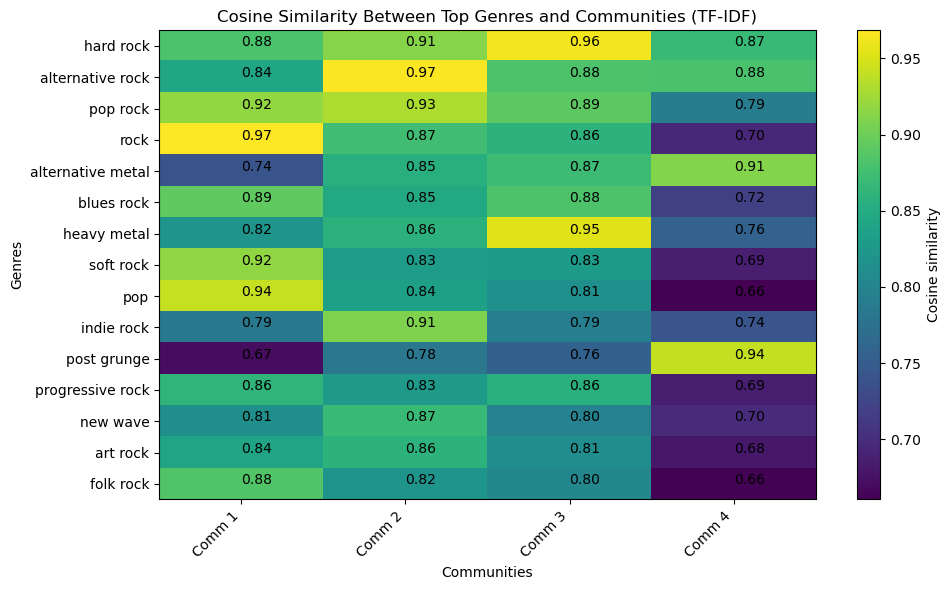

In [74]:
similarity_matrix = cosine_similarity(averaged_genres_tfidf[:15], averaged_community_tfidf)

# Everything below this here is just for plotting the similarity matrix
plt.figure(figsize=(10, 6))
im = plt.imshow(similarity_matrix, cmap="viridis", aspect="auto")

plt.colorbar(im, label="Cosine similarity")

plt.xticks(ticks=np.arange(len(louv_comm)), labels=[f"Comm {i+1}" for i in range(len(louv_comm))], rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(averaged_genres_labels[:15])), labels=averaged_genres_labels[:15])

# Annotate the matrix with similarity values
for i in range(len(top_genres)):
    for j in range(len(louv_comm)):
        val = similarity_matrix[i, j]
        plt.text(j, i, f"{val:.2f}")

plt.title("Cosine Similarity Between Top Genres and Communities (TF-IDF)")
plt.xlabel("Communities")
plt.ylabel("Genres")
plt.tight_layout()
plt.show()


Now we can clearly see the results! Community 1 represents alternative rock, Community 2 corresponds to rock, Community 3 could be hard rock or heavy metal, and Community 4 aligns with post-grunge. When we relate this back to the confusion matrix D, we see clear similarities. Community 1 is also associated with alternative rock, and Community 3 is linked to both hard rock and heavy metal.

# Part 4: Sentiment of artists and communities

- Calculate the sentiment of the band/artist pages (it is OK to work with the sub-network of artists-with-genre) and describe your findings using stats and visualization, inspired by the first exercise of week 8.
- Discuss the sentiment of the communities. Do the findings using TF-IDF during Lecture 7 help you understand your results?

Lets calculate the sentiment of band/artist pages. For this we will use the LabMT English V2 dataset from [hedonometer.org](https://hedonometer.org/words/labMT-en-v2/)

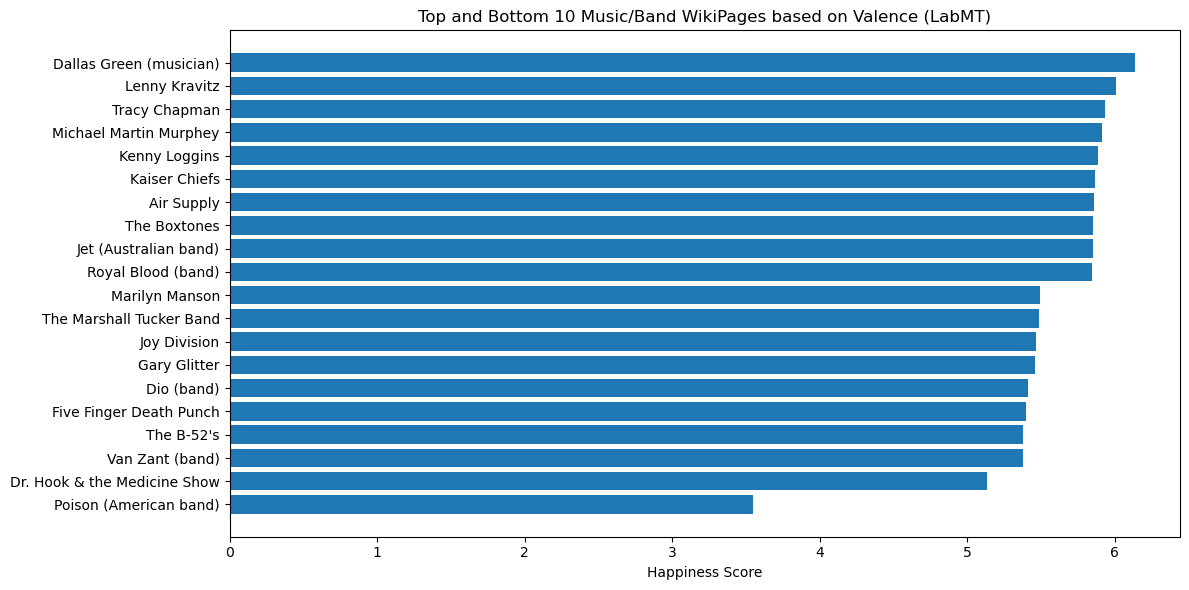

In [75]:
# First we load the dataset
labmt = pd.read_csv("Hedonometer.csv")

# Next we convert the word list into a dictionary for O(1) lookups
hedonometer_dict = {}
for _, row in labmt.iterrows():
    word = str(row['Word']).lower()
    score = row['Happiness Score']
    hedonometer_dict[word] = score

sd_dict = {}
for _, row in labmt.iterrows():
    word = str(row['Word']).lower()
    score = row['Standard Deviation of Ratings']
    sd_dict[word] = score

# Next we will be calculating the happiness score of a text, given word frequencies:
# We will incorporate standard deviation weighting.
# We can reuse the tokenized texts and word frequencies from before
# The formula we will use is:
# Happiness Score = Σ ( (TF(t) / (SD(t)^2)) * H(t) ) / Σ ( TF(t) / (SD(t)^2) )

musicians_valence = {}

# Now we compute the happiness score for each musician
for musician in musicians_cleaned_text:
    text = musicians_cleaned_text[musician]
    term_frequencies = term_counts_per_musician[musician]
    terms = list(term_frequencies.keys())
    total_words = len(text)

    numerator = 0.0
    denominator = 0.0

    for term in terms:
        t = term.lower()
        if t in hedonometer_dict and t in sd_dict:
            count = term_frequencies[term]
            happiness = hedonometer_dict[t]
            sd = sd_dict[t]
            if sd and sd > 0:
                weight = count / (sd * sd)
                numerator += weight * happiness
                denominator += weight

    happiness_score = (numerator / denominator)
    musicians_valence[musician] = happiness_score

musicians_valence_sorted = dict(sorted(musicians_valence.items(), key=lambda item: item[1], reverse=True))

# We select the top 10 and bottom 10 for visualization
top_10_happy = list(musicians_valence_sorted.items())[:10]
bottom_10_happy = list(musicians_valence_sorted.items())[-10:]

visualize_happiness_data = top_10_happy + bottom_10_happy

musicians = [m for m, _ in visualize_happiness_data]
scores = [s for _, s in visualize_happiness_data]


# Now we plot the results
plt.figure(figsize=(12, 6))
plt.barh(musicians, scores)
plt.gca().invert_yaxis()
plt.xlabel("Happiness Score")
plt.title("Top and Bottom 10 Music/Band WikiPages based on Valence (LabMT)")
plt.tight_layout()
plt.show()


Now that we can calculate scores based on artists, lets see how they correlate to communities:

In [76]:
community_valence = []

# Now we calculate the average valence score per community
for i, bands in enumerate(louv_comm, start=1):
    valence_scores = [
        musicians_valence[b] for b in bands 
        if b in musicians_valence and not np.isnan(musicians_valence[b])
    ]
    average_valence = sum(valence_scores) / len(valence_scores)
    print(f"Community {i} with {len(bands)} artists has an average score of {average_valence:.4f}")
    community_valence.append((i, average_valence, len(bands)))



Community 1 with 161 artists has an average score of 5.6948
Community 2 with 151 artists has an average score of 5.6976
Community 3 with 121 artists has an average score of 5.6246
Community 4 with 51 artists has an average score of 5.6859


As you can see, the averages of valence between communities is not that much. This is not surprising as our source material is wikipedia, which in general is written in a more neutral tone. Additionally, our current lack of lemmatisation may also hurt our word coverage and thus our valence score calculation. Comparing it to our TF-IDF results, we see a similar pattern. Although there were some larger differences in the TF-IDF results, the genres were still relatively close to each other, just like our communities. Thus, it would make sense that valence scores were relatively similar. Also considering our communities are relatively large, it would be logical that it would approach the global average.

# Division of Work
Part 1 and 2: Ben Berger s252255

Part 3 and 4: Duco Lam s252126

Essentially 50/50

Proof reading together
